## Data Preprocessing Steps

### Type 1 (in accordance with torch.hub)
1. Get basic shapes (#=51) and their rotations (from 1-8).
2. Scale s.t. in interval [0, 1].
3. Normalize to mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225].
4. Adjust according to light or dark: dark = 2*mean - light. This reflects light w.r.t. the mean
5. Adjust according to scale: out_array = (1-scale)\*mean + scale*in_array.

### Type 2
1. Get basic shapes (#=51) and their rotations (from 1-8).
2. Scale s.t. in interval [0, 1].
3. Adjust according to light or dark: dark = light*(-1).
4. Adjust according to scale: out_array = in_array*scale.

In [2]:
preprocess = 2

## Fill-Outline Invariance

### An Example

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import handytools.navigator as nav

In [4]:
def get_r2(datatype, mtype, key, preprocess):
    metrics = nav.pklload("/src", "results", f"{datatype}_{mtype}", f"key={key}_preproc={preprocess}", "fit_metrics.pkl")
    metrics_array = np.asarray(list(metrics.values())) # shape = (# responsive units, # metrics)
    r2_filtered = np.maximum(metrics_array[:,2], 0) # ReLU(r^2)
    return r2_filtered, list(metrics.keys())

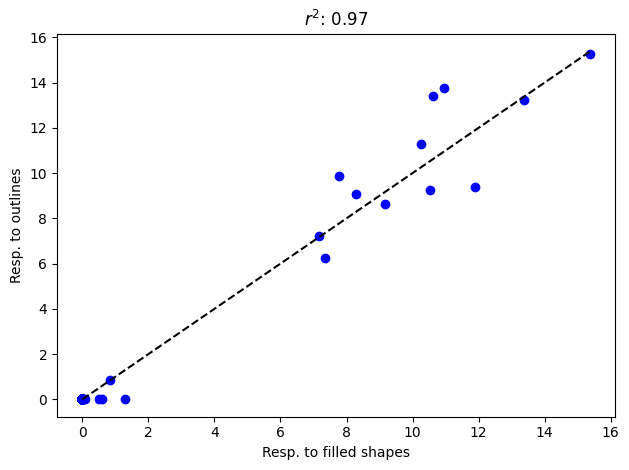

In [14]:
R_fill = nav.npload("/src", "results", f"responses_AN", f"key=8_hollow=0_scale=1_light=1_lw=1_preproc={preprocess}.npy")
R_holl = nav.npload("/src", "results", f"responses_AN", f"key=8_hollow=1_scale=1_light=1_lw=1_preproc={preprocess}.npy")
r2, idx = get_r2("filloutline", "AN", 8, preprocess)

s1 = list(r2).index(max(r2))
s2 = idx[s1]
plt.scatter(R_fill[s2], R_holl[s2], color="b")
minn = min([min(R_fill[s2]), min(R_holl[s2])])
maxx = max([max(R_fill[s2]), max(R_holl[s2])])
plt.plot([minn, maxx], [minn, maxx], "k--") # plot x=y
plt.xlabel("Resp. to filled shapes"); plt.ylabel("Resp. to outlines"); plt.title(f"$r^2$: {round(r2[s1],2)}") 
plt.tight_layout(); plt.show()

### AlexNet

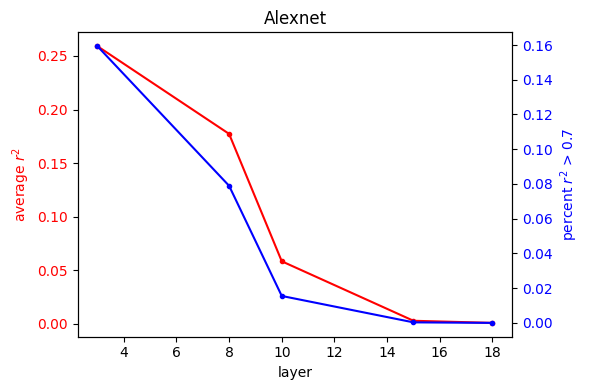

In [15]:
avg_r2, perc_r2 = [], []
layers = [3,8,10,15,18]

for hk in layers:
    r2 = get_r2("filloutline", "AN", hk, preprocess)[0]
    avg_r2.append(np.mean(r2))
    perc_r2.append(sum(r2 >= 0.7)/len(r2))

fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(layers, avg_r2, "r.", linestyle="-")
ax1.set_xlabel('layer'); ax1.set_ylabel('average $r^2$', color="r")
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx()
ax2.plot(layers, perc_r2, "b.", linestyle="-")
ax2.set_xlabel('layer'); ax2.set_ylabel('percent $r^2$ > 0.7', color="b")
ax2.tick_params(axis='y', labelcolor="b")

plt.title("Alexnet")
plt.tight_layout(); plt.show()

### VGG 16

Text(0.5, 1.0, 'VGG 16')

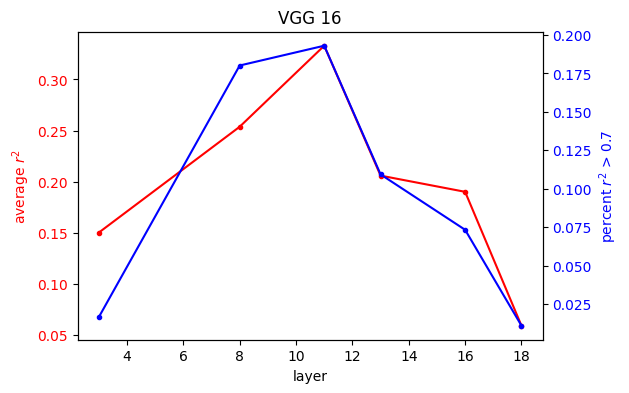

In [16]:
avg_r2, perc_r2 = [], []
layers = [3,8,11,13,16,18]

for hk in layers:
    r2 = get_r2("filloutline", "VGG16", hk, preprocess)[0]
    avg_r2.append(np.mean(r2))
    perc_r2.append(sum(r2 >= 0.7)/len(r2))

fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(layers, avg_r2, "r.", linestyle="-")
ax1.set_xlabel('layer'); ax1.set_ylabel('average $r^2$', color="r")
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx()
ax2.plot(layers, perc_r2, "b.", linestyle="-")
ax2.set_xlabel('layer'); ax2.set_ylabel('percent $r^2$ > 0.7', color="b")
ax2.tick_params(axis='y', labelcolor="b")

plt.title("VGG 16")

## On-Off Invariance vs. Fill-Outline Invariance

Is fill-outline invariance correlated with on-off invariance?

### Alexnet

In [6]:
def combine_dict(d1, d2):
    return {
        k: [d[k] for d in (d1, d2)]
        for k in set(d1.keys()) & set(d2.keys())
    }

def get_dict(keys, values):
    dic = {}
    for i, key in enumerate(keys): dic[key] = values[i]
    return dic

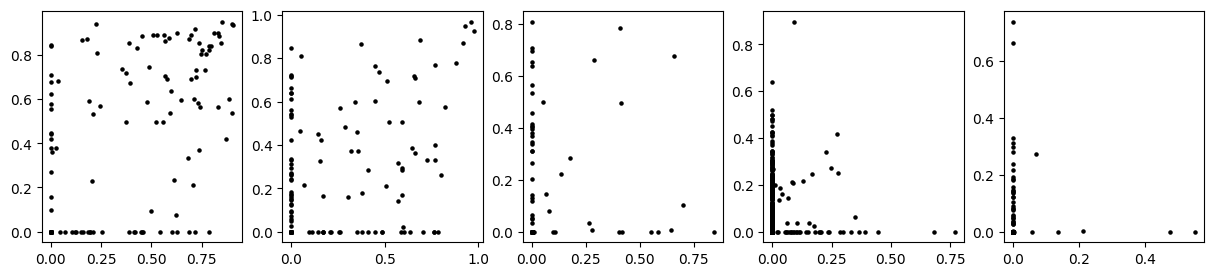

In [6]:
avg_r2, perc_r2 = [], []
layers = [3,8,10,15,18]

fig = plt.figure(figsize=(3*len(layers), 3))
for i, hk in enumerate(layers):
    r2_foi, idx_foi = get_r2("filloutline", "AN", hk, preprocess)
    r2_ooi, idx_ooi = get_r2("onoff", "AN", hk, preprocess)
    foi_dic = get_dict(idx_foi, r2_foi)
    ooi_dic = get_dict(idx_ooi, r2_ooi)
    new_dic = combine_dict(foi_dic, ooi_dic)

    x, y = np.asarray(list(new_dic.values())).T
    ax = fig.add_subplot(1, len(layers), i+1)
    ax.scatter(x, y, color="k", s=5)

### VGG16

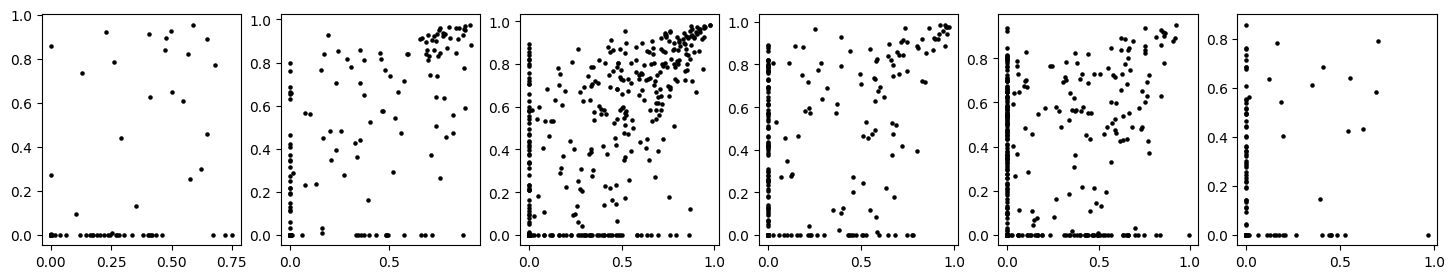

In [7]:
avg_r2, perc_r2 = [], []
layers = [3,8,11,13,16,18]

fig = plt.figure(figsize=(3*len(layers), 3))
for i, hk in enumerate(layers):
    r2_foi, idx_foi = get_r2("filloutline", "VGG16", hk, preprocess)
    r2_ooi, idx_ooi = get_r2("onoff", "VGG16", hk, preprocess)
    foi_dic = get_dict(idx_foi, r2_foi)
    ooi_dic = get_dict(idx_ooi, r2_ooi)
    new_dic = combine_dict(foi_dic, ooi_dic)

    x, y = np.asarray(list(new_dic.values())).T
    ax = fig.add_subplot(1, len(layers), i+1)
    ax.scatter(x, y, color="k", s=5)

## Dynamic Range Invariance vs. Fill-Outline Invariance

Is fill-outline invariance correlated with dynamic range invariance?

### VGG16

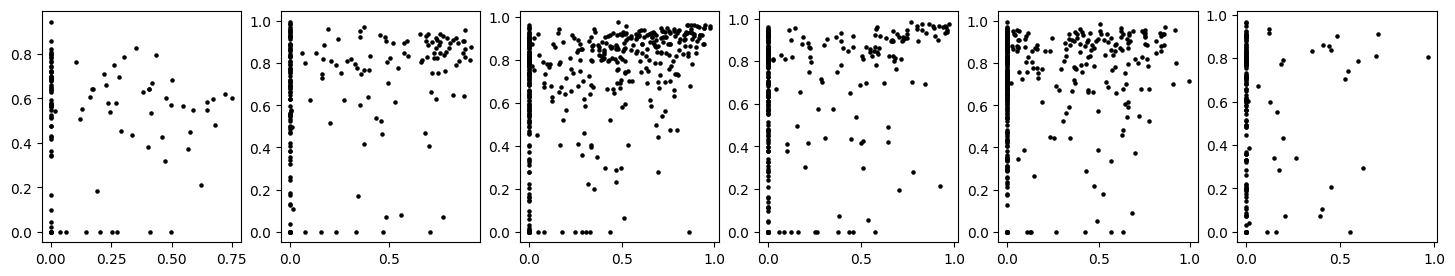

In [9]:
avg_r2, perc_r2 = [], []
layers = [3,8,11,13,16,18]

fig = plt.figure(figsize=(3*len(layers), 3))
for i, hk in enumerate(layers):
    r2_foi, idx_foi = get_r2("filloutline", "VGG16", hk, preprocess)
    r2_ooi, idx_ooi = get_r2("range", "VGG16", hk, preprocess)
    foi_dic = get_dict(idx_foi, r2_foi)
    ooi_dic = get_dict(idx_ooi, r2_ooi)
    new_dic = combine_dict(foi_dic, ooi_dic)

    x, y = np.asarray(list(new_dic.values())).T
    ax = fig.add_subplot(1, len(layers), i+1)
    ax.scatter(x, y, color="k", s=5)